#Simplified stock trading bot with basic machine learning 

This will review the process for a single stock to use some of the most advanced machine learning techniques in order to improve the prediction accuracy of time series predictions. For our purposes we will use Apples stock and we will focus on day closing predictions as that is the most easily available data. This type of prediction is more akin to swing trading. Day Trading would be better to use the per minute or per 5 minute information. 

This notebook will cover making predictions and connect to alpaca to make orders. It is not going to do the full trading bot as you will need to learn your own strategies for that. 

#Things to do:


1.   Install Libraries 
2.   Load Data 
3.   Transform the data - Typically more work to be done here, but one feature should be able to standardize and normalize itself through simple pipeline functions.  

1.   List item
2.   List item


4.   Train the Model - We will try a few different models here 
5.   Evaluate Model 
6.   Connect it to alpaca 



In [0]:
#Install the Libiraries 
!pip install alpaca-trade-api
!pip install sklearn
!pip install pandas
!pip install matplotlib

In [0]:
#Loader 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [0]:
#Load the data 
#anything to do pull the data in 
#np.random.seed(42)

AAPL= pd.read_csv("AAPL.csv").drop(['Close'], axis=1)
AAPL.set_index('Date', drop=True, inplace=True)

In [0]:
#Review the data 
AAPL.head()

,Open,High,Low,Adj Close,Volume
Date,,,,,
2013-12-30,79.637146,80.012856,78.902855,67.420517,63407400
2013-12-31,79.167145,80.182854,79.142860,68.210831,55771100
2014-01-02,79.382858,79.575714,78.860001,67.251503,58671200
2014-01-03,78.980003,79.099998,77.204285,65.774300,98116900
2014-01-06,76.778572,78.114288,76.228569,66.132957,103152700


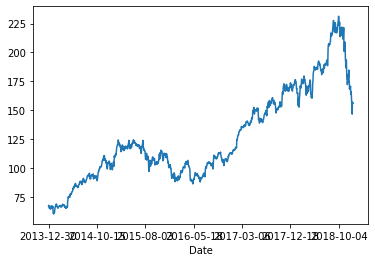

In [0]:
#Plot the data to review 
AAPL['Adj Close'].plot()

In [0]:
#Split the datta and Prep it for machine learning by by time lag or shift 
X = AAPL['Adj Close'].shift(10).dropna()
y = AAPL['Adj Close']

trainX, testX, trainY, testY = train_test_split(X.values, y[10:].values, test_size=.2)

trainX, trainY, testX, testY = trainX.reshape(-1, 1), trainY.reshape(-1, 1), testX.reshape(-1, 1), testY.reshape(-1, 1)

#Linear Regression Model 

In [0]:
#Simple linear regression model definition along with transformation pipeline 
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])


In [0]:
kfold = KFold(n_splits=10)
lr_score = cross_val_score(lr, trainX, trainY, cv=kfold, scoring='neg_mean_squared_error')


In [0]:
lr_score.mean()

-44.11564926863038

In [0]:
# Review predictions against the remaining data 
lr.fit(trainX, trainY)

preds = lr.predict(testX)

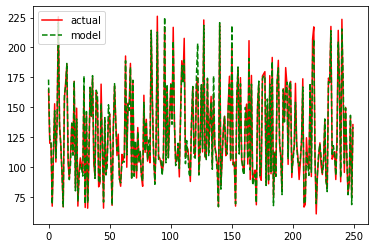

In [0]:
#Plot data for review 
plt.plot([a for a in range(len(testY))], testY, 'r-', label='actual')
plt.plot([a for a in range(len(preds))], preds, 'g--', label='model')
plt.legend()
plt.show()

In [0]:
#Make single prediction to ensure model seems accurate and not way off 
lr.predict([[165.48]])

array([[165.22484845]])

# Backtesting the results with the hold outs. 


In [0]:
backtest = pd.read_csv("AAPL_Backtest.csv")
backtest.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,30.447144,30.478571,30.080000,30.104286,20.159719,88102700
1,2010-01-04,30.490000,30.642857,30.340000,30.572857,20.473503,123432400
2,2010-01-05,30.657143,30.798571,30.464285,30.625713,20.508902,150476200
3,2010-01-06,30.625713,30.747143,30.107143,30.138571,20.182680,138040000
4,2010-01-07,30.250000,30.285715,29.864286,30.082857,20.145369,119282800


In [0]:
errors = []
counter = 0
pred = None
maxprice = 0;
avgprice = 0; 
#Get the average amount off per prediction 
#This is our average error per call 
#Max and Min would also be important here
for price in backtest['Adj Close'].values[::1000]:
  absprice = abs(price)
  if absprice > maxprice:
    maxprice = price
  if counter == 0:
    pred = lr.predict([[price]])
  else:
    errors.append(pred - price)
    pred = lr.predict([[price]])
  counter += 1
#Over short periods of time such as 10 values the error might seem erroneously low deviation
print("Avg error in dollars: ", (sum(errors) / len(errors)))
print("Max difference: ", maxprice)

Avg error in dollars:  [[-43.47646708]]
Max difference:  66.751823


#Portforlio Review and Trade Decision Logic 
For our purposes we willjust show you how to connect to the API and make your orders or sales. You will need to add your own logic for this portion. 

In [0]:
#Connect to the Alpaca API to get current positions 
import alpaca_trade_api as alpaca
api = alpaca.REST('My_Key', 'My_Secret', 'https://paper-api.alpaca.markets', api_version='v2')

In [0]:
api.get_account()
api.list_positions()